### Univariate TS Analysis and Forecasting Example

Will try:
- traditional stats modelk (SARIMA)
- DL model (LSTM)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from itertools import product
%matplotlib inline

In [2]:
fire_data = pd.read_csv('dataset/amazon.csv',encoding='latin1')

In [3]:
fire_data.head()

,year,state,month,number,date
0,1998,Acre,Janeiro,0.0,1998-01-01
1,1999,Acre,Janeiro,0.0,1999-01-01
2,2000,Acre,Janeiro,0.0,2000-01-01
3,2001,Acre,Janeiro,0.0,2001-01-01
4,2002,Acre,Janeiro,0.0,2002-01-01


In [4]:
# check if there is invalid data value in the dataframe
fire_data.isnull().sum()

year      0
state     0
month     0
number    0
date      0
dtype: int64

In [5]:
gb=fire_data.groupby('state')
states_df = [gb.get_group(x) for x in gb.groups]
print(len(states_df))

23


In [6]:
states_df[2].head()

,year,state,month,number,date
479,1998,Amapa,Janeiro,0.0,1998-01-01
480,1999,Amapa,Janeiro,0.0,1999-01-01
481,2000,Amapa,Janeiro,2.0,2000-01-01
482,2001,Amapa,Janeiro,0.0,2001-01-01
483,2002,Amapa,Janeiro,7.0,2002-01-01


### Pick just one state to start the prediction task

In [7]:
target_df= states_df[2]

### Drop the incorrect and redundant column 'date'

In [8]:
target_df = target_df.loc[:, ['year', 'state','month','number']]
target_df.head()

,year,state,month,number
479,1998,Amapa,Janeiro,0.0
480,1999,Amapa,Janeiro,0.0
481,2000,Amapa,Janeiro,2.0
482,2001,Amapa,Janeiro,0.0
483,2002,Amapa,Janeiro,7.0


In [9]:
# Create the month mapping from latin to numbers
month_keys = set(target_df['month'])
# print(month_keys)
month_dict={
    'Março': 3, 
    'Junho': 6, 
    'Abril': 4, 
    'Setembro': 9,
    'Fevereiro': 2, 
    'Agosto': 8,
    'Maio': 5,
    'Novembro': 11,
    'Janeiro':1, 
    'Julho': 7,
    'Dezembro': 12,
    'Outubro':10
}
# convert month to sortabke numerical values
target_df['month'] = target_df['month'].apply(lambda x: month_dict[x])
target_df.head()

,year,state,month,number
479,1998,Amapa,1,0.0
480,1999,Amapa,1,0.0
481,2000,Amapa,1,2.0
482,2001,Amapa,1,0.0
483,2002,Amapa,1,7.0


### Combine year and month, add an arbitrary date, and set it as index of df

In [10]:
target_df['day']=1
target_df.index=pd.DatetimeIndex(pd.to_datetime(target_df[['year', 'month','day']]))
target_df.sort_index(inplace=True,ascending=True)
target_df = target_df.loc[:, ['number']] # drop all irrelavant columns
target_df.head()

,number
1998-01-01,0.0
1998-02-01,0.0
1998-03-01,0.0
1998-04-01,0.0
1998-05-01,0.0


In [11]:
target_df.tail()

,number
2017-07-01,3.0
2017-08-01,33.0
2017-09-01,95.0
2017-10-01,468.0
2017-11-01,858.0


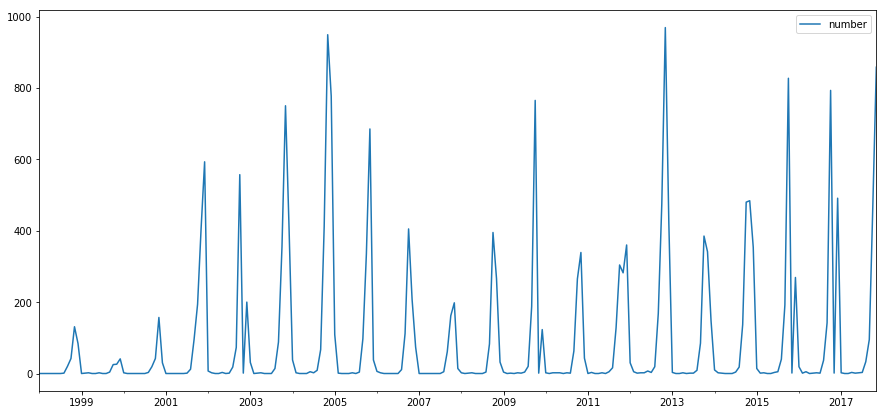

In [12]:
# plot the entire TS
fig, ax = plt.subplots(figsize=(15,7))
target_df.plot(y='number',ax=ax)

Looks like there may be a cyclic pattern on a yearly basis.
Let's decompose the signal and look at trend, seasonality and residuals.

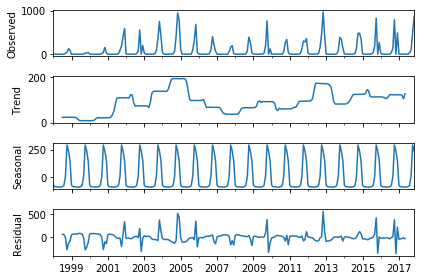

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(target_df.number, model='additive')
result.plot()
plt.show()

Observations so far:
1. Data is discrete Time Series with evenly distributed samples over time (once per month)
2. No obvious trend maybe a little upward observed
3. Clear cyclic pattern or seasonality observed
4. No missing data observed
Let's start with traditional stats model. AR, MA ot ARMA models cannot handle seasonality or trend very well. 
ARIMA handles trend but not seasonality, so I will go with SARIMA to approach this problem. Plus you can always tweek the parameters of SARIMA to make it ARIMA, ARMA, AR or MA models.

In [14]:
print(target_df.tail())
data = target_df.number
dates=target_df.index

            number
2017-07-01     3.0
2017-08-01    33.0
2017-09-01    95.0
2017-10-01   468.0
2017-11-01   858.0


In [15]:
# grid search sarima hyperparameters
from math import sqrt

from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# one-step sarima forecast
def sarima_forecast(history, config):
    # config = [p,d,q, P,D,Q,m,]
    order, sorder = tuple(config[0:3]), tuple(config[3:])
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [16]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [17]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [18]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return predictions, error

In [19]:
# score a model, return None on failure
def score_model(df, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                order, sorder = tuple(cfg[0:3]), tuple(cfg[3:])
                # define model
                model = SARIMAX(df.number, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False)
                # fit model
                model_fit = model.fit(disp=False)
                pred = model_fit.get_prediction(start=pd.to_datetime('2013-12-01'), dynamic=False)
                predicted = pred.predicted_mean
                truth=df['2013-12-01':]
                result = measure_rmse(truth, predicted)
#                 _, result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [20]:
import multiprocessing
from functools import partial
from contextlib import contextmanager

@contextmanager
def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()
    
# grid search configs
def grid_search(df, cfg_list, n_test, parallel=False):
    scores = None
    if parallel:
        # execute configs in parallel
        with poolcontext(processes=4) as pool:    
            scores = pool.map(partial(score_model, df, n_test), cfg_list) # pass full list (12 items)

    else:
        scores = [score_model(df, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [21]:
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    # define config lists
    # all order parameter in [0,2] inclusive, should be sufficient for this dataset
    p_params = np.arange(3)
    d_params = np.arange(2)
    q_params = np.arange(3)
    
    P_params = np.arange(3)
    D_params = np.arange(2)
    Q_params = np.arange(3)
    m_params = seasonal
    
#     t_params = ['n','c','t','ct']
    models = list(product(p_params,d_params,q_params,P_params,D_params,Q_params,m_params))
    return models

In [22]:
# # test the process with contrived dataset
# data = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.] #target_df.number

# # data split
# n_test = 4 #12

# # model configs
# # The period of the seasonal component is about one year, or 12 observations. 
# # We will use this as the seasonal period in the call to the sarima_configs() function when preparing the model configurations.
# cfg_list = sarima_configs(seasonal=[0,12])
# # grid search
# scores = grid_search(data, cfg_list, n_test, parallel=True)
# print('done')
# # list top 3 configs
# for cfg, error in scores[:3]:
#     print(cfg, error)

In [23]:
# Now do it with real data
# test the process with contrived dataset
# data = target_df.number

# data split
n_test = 4*12 # 4 years data for testing

# model configs
# The period of the seasonal component is about one year, or 12 observations. 
# We will use this as the seasonal period in the call to the sarima_configs() function when preparing the model configurations.
cfg_list = sarima_configs(seasonal=[12])
# grid search
scores = grid_search(target_df, cfg_list, n_test, parallel=True)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[(0, 0, 0, 0, 0, 0, 12)] 261.537
 > Model[(0, 1, 0, 1, 1, 0, 12)] 246.578
 > Model[(0, 0, 1, 0, 1, 0, 12)] 173.374
 > Model[(0, 0, 2, 1, 0, 0, 12)] 175.556
 > Model[(0, 0, 0, 0, 0, 1, 12)] 213.102
 > Model[(0, 0, 1, 0, 1, 1, 12)] 156.419
 > Model[(0, 0, 0, 0, 0, 2, 12)] 193.224
 > Model[(0, 0, 0, 0, 1, 0, 12)] 171.353
 > Model[(0, 1, 0, 1, 1, 1, 12)] 219.660
 > Model[(0, 0, 2, 1, 0, 1, 12)] 148.813
 > Model[(0, 0, 0, 0, 1, 1, 12)] 146.567
 > Model[(0, 0, 2, 1, 0, 2, 12)] 144.068
 > Model[(0, 0, 2, 1, 1, 0, 12)] 174.242
 > Model[(0, 0, 0, 0, 1, 2, 12)] 147.015
 > Model[(0, 0, 0, 1, 0, 0, 12)] 170.696
 > Model[(0, 0, 0, 1, 0, 1, 12)] 139.445
 > Model[(0, 0, 2, 1, 1, 1, 12)] 152.197
 > Model[(0, 0, 1, 0, 1, 2, 12)] 152.718
 > Model[(0, 0, 1, 1, 0, 0, 12)] 175.285
 > Model[(0, 0, 0, 1, 0, 2, 12)] 138.285
 > Model[(0, 0, 0, 1, 1, 0, 12)] 167.993
 > Model[(0, 0, 1, 1, 0, 1, 12)] 148.788
 > Model[(0, 0, 0, 1, 1, 1, 12)] 147.133
 > Model[(0, 1, 0, 1, 1, 2, 12)] 217.333
 > Model[(0, 0, 

### Top 3 Configs:
- (0, 0, 0, 2, 0, 2, 12) 136.30610258491282
- (0, 0, 0, 1, 0, 2, 12) 138.28472592710722
- (0, 0, 0, 2, 0, 1, 12) 139.29992703766936

In [24]:
# The best option for config is SARIMA (0, 0, 0)x(2, 0, 2, 12)
with catch_warnings():
    filterwarnings("ignore")
    mod = SARIMAX(target_df.number,
                order=(0, 0, 0),
                seasonal_order=(2, 0, 2, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4843      0.066      7.330      0.000       0.355       0.614
ar.S.L24       0.5669      0.067      8.441      0.000       0.435       0.698
ma.S.L12      -0.2399      0.074     -3.247      0.001      -0.385      -0.095
ma.S.L24      -0.7601      0.065    -11.670      0.000      -0.888      -0.632
sigma2      1.635e+04   4.39e-06   3.73e+09      0.000    1.63e+04    1.63e+04


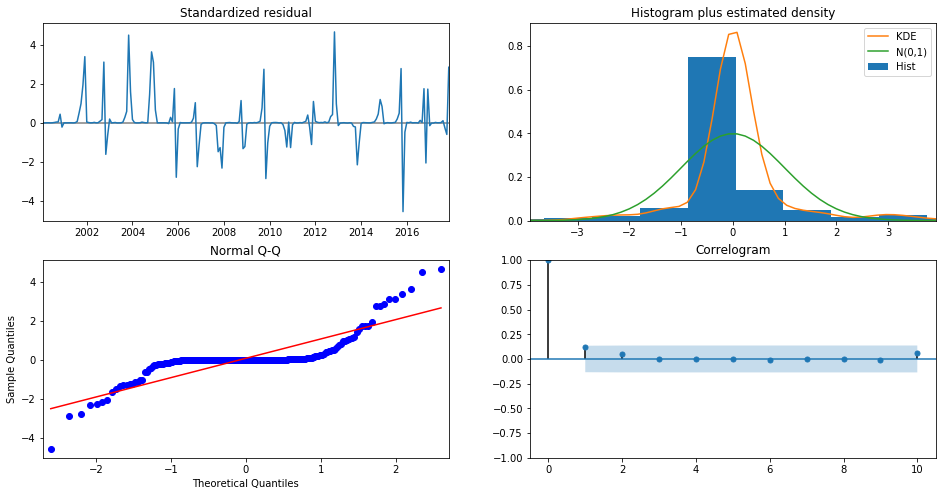

In [25]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2013-12-01'), dynamic=False)

pred_ci = pred.conf_int()

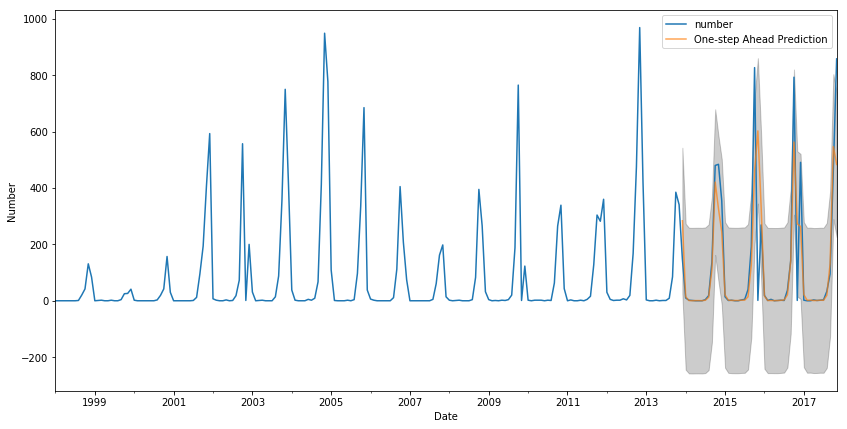

In [27]:
ax = target_df['1998':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number')
plt.legend()
plt.show()

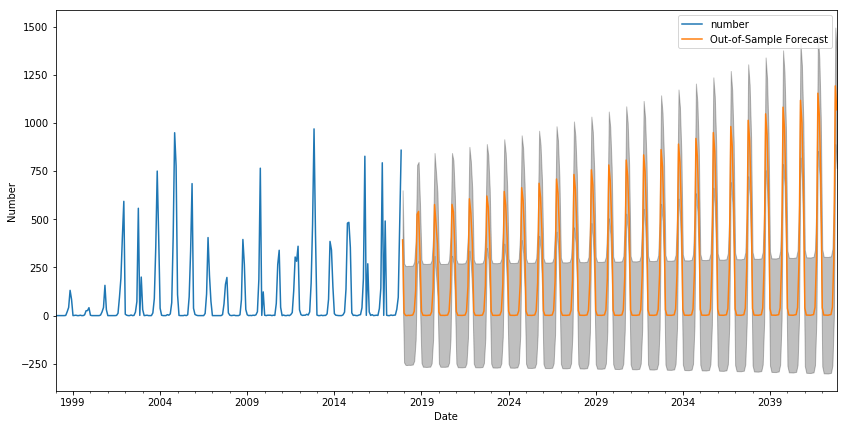

In [36]:
pred_uc = results.get_forecast(steps=300)
pred_ci = pred_uc.conf_int()
ax = target_df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Out-of-Sample Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Number')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
# plt.plot(data)
print(type(data))
print(type(predictions))
x=dates[-n_test:]
print(predictions)
plt.plot(x,predictions,label='predicted')
plt.plot(x,data[-n_test:],label='gt')
plt.legend(loc='best')
plt.show(block=False)
plt.close()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

# determine rolling statistics
rol_mean = target_df['number'].rolling(12).mean()
rol_std = target_df['number'].rolling(12).std()
# plot rolling statistics vs. original TS
# fig, ax = plt.subplots(figsize=(15,7))
fig1, ax1 = plt.subplots(figsize=(15,7))
orig = plt.plot(target_df['number'],color='blue',label='original')
mean = plt.plot(rol_mean,color='red',label='rolling mean')
std = plt.plot(rol_std,color='black',label='rolling std')
plt.legend(loc='best')
plt.show(block=False)
plt.close()

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary

In [ ]:
result = adfuller(target_df['number']) # Augmented Dickey Fuller test 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In this case, 0.089 > 0.05. Let's find out the order of differencing.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(15,12),sharex=False)
axes[0, 0].plot(target_df['number'])
axes[0, 0].set_title('Original Series')
plot_acf(target_df['number'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(target_df['number'].diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(target_df['number'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(target_df['number'].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(target_df['number'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In this case, choose d=1